#Nifty 50 Index Prediction Pipeline

###Importing Libraries

In [74]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Dense, LSTM
import pickle

import warnings
warnings.filterwarnings("ignore")

import random
from sklearn.metrics import mean_squared_error
from math import sqrt

###Defining Functions

In [75]:
def create_model():
    model = Sequential()
    model.add(LSTM(units=128, activation='tanh', kernel_initializer=tf.keras.initializers.glorot_uniform(seed=26), input_shape = (61,1)))
    model.add(Dense(1, name="output_layer"))
    return model

In [78]:
#Function to Predict Next Day Index Price

def prediction_single_day(date):  #date: Enter date for which you want next day's price prediction.
    
    #Loading Data
    data = pd.read_csv('data_processed_final.csv')
    with open('min_max.pickle', 'rb') as i:
        minmax = pickle.load(i)

    #Predicting
    data['price'] = minmax.transform(data['price'].values.reshape(-1, 1))

    model = create_model()
    model.load_weights('LSTM_with_Sentiments.h5')

    try:
        present_day = data[data['date'] == date].index[0]

        last_60_days_price = data['price'][present_day-59:present_day+1].values
        last_day_news_score = data[data['date'] == date]['score']

        prediction_array = np.append(last_60_days_price, last_day_news_score).reshape(-1, 1)
        prediction_array = np.expand_dims(prediction_array, axis=0)
        
        print("Predicting Next Working Day's Nifty 50 Index Price...\n")

        predicted_stock_price = model.predict(prediction_array)
        predicted_stock_price = minmax.inverse_transform(predicted_stock_price)
        predicted_stock_price = predicted_stock_price[0][0]

        actual_price = data['price'][present_day]
        actual_price = minmax.inverse_transform([[actual_price]])
        actual_price = actual_price[0][0]

        print(f'Predicted Index Price for the next working day after {date}: {predicted_stock_price}')
        print(f'Actual Index Price for the next working day after {date}: {actual_price}\n')

    except (IndexError, UnboundLocalError):
        print('Entered Date should lie between period 2015-01-01 and 2019-12-31 and should not lie on a stock market holiday. Please enter a correct date.')

    except:
        print('Invalid Date Format. Please put date in yyyy-mm-dd format.')

In [79]:
#Function to Predict Price for Random 60 Consecutive Days

def prediction_multiple_days():

    #Loading Data
    data = pd.read_csv('data_processed_final.csv')
    with open('min_max.pickle', 'rb') as i:
        minmax = pickle.load(i)

    #Predicting
    data['price'] = minmax.transform(data['price'].values.reshape(-1, 1))
    
    prediction_prices = []
    actual_prices = []

    random.seed(20)
    n = random.randint(0, len(data)-60)
    random_date = data['date'][n]
    print(f'Predicting for next 60 days from date: {random_date}')

    model = create_model()
    model.load_weights('LSTM_with_Sentiments.h5')

    for i in range(n, n+60):
        date = data['date'][i]

        present_day = data[data['date'] == date].index[0]

        last_60_days_price = data['price'][present_day-59:present_day+1].values
        last_day_news_score = data[data['date'] == date]['score']

        prediction_array = np.append(last_60_days_price, last_day_news_score).reshape(-1, 1)
        prediction_array = np.expand_dims(prediction_array, axis=0)

        predicted_stock_price = model.predict(prediction_array)
        predicted_stock_price = minmax.inverse_transform(predicted_stock_price)
        predicted_stock_price = predicted_stock_price[0][0]

        actual_price = data['price'][present_day]
        actual_price = minmax.inverse_transform([[actual_price]])
        actual_price = actual_price[0][0]

        prediction_prices.append(predicted_stock_price)
        actual_prices.append(actual_price)

    plt.figure(figsize=(12,7))
    plt.plot(prediction_prices, color = 'red', label = 'Predicted Prices')
    plt.plot(actual_prices, color = 'green', label = 'Actual Prices')
    plt.title('Nifty Index Prediction for 60 Consecutive Days')
    plt.xlabel('Days')
    plt.ylabel('Prices')
    plt.legend()
    plt.show()

    RMSE = sqrt(mean_squared_error(prediction_prices, actual_prices))
    print(f"RMSE: {RMSE}")

###Predicting Next Day Price

In [80]:
%%time
prediction_single_day('2021-01-03')  #Printing output when you give a faulty date

Entered Date should lie between period 2015-01-01 and 2019-12-31 and should not lie on a stock market holiday. Please enter a correct date.
CPU times: user 332 ms, sys: 8.91 ms, total: 341 ms
Wall time: 343 ms


In [81]:
%%time
prediction_single_day('2018-01-23')  #Printing output when you give a correct date

Predicting Next Working Day's Nifty 50 Index Price...

Predicted Index Price for the next working day after 2018-01-23: 11079.4794921875
Actual Index Price for the next working day after 2018-01-23: 11083.7

CPU times: user 639 ms, sys: 14.9 ms, total: 654 ms
Wall time: 649 ms


###Predicting 60 Consecutive Days Price

In [82]:
data = pd.read_csv('data_processed_final.csv')

data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1232 entries, 0 to 1231
Data columns (total 5 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   date                 1232 non-null   object 
 1   tweet_news_combined  1232 non-null   object 
 2   score                1232 non-null   float64
 3   sentiment            1232 non-null   float64
 4   price                1232 non-null   float64
dtypes: float64(3), object(2)
memory usage: 48.2+ KB


Predicting for next 60 days from date: 2016-04-01


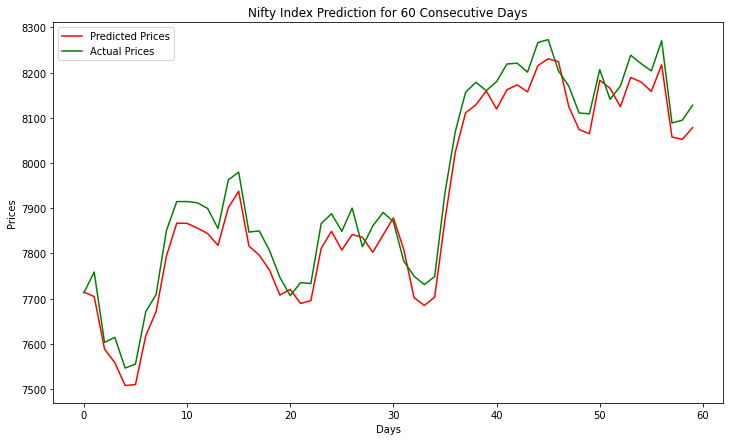

RMSE: 44.35698436462765
CPU times: user 3.75 s, sys: 68.2 ms, total: 3.82 s
Wall time: 3.64 s


In [97]:
%%time
prediction_multiple_days()

#Post-Training Quantization

**Quantization** refers to techniques for performing computations and storing tensors at lower bitwidths than floating point precision. A quantized model executes some or all of the operations on tensors with integers rather than floating point values. This allows model to run faster but this comes at a cost of accuracy.

 By default, the model weights are saved in Float32 format but it can be reduced to Float16 or Int8 to get the calculations faster but due to approximation we can expect a little drop in the accuracy.

 As we can see above that it currently takes around 800ms for our model to predict the next price. Here, with the help of quantization techniques we will try to reduce this runtime of our model.

###Defining Functions for Quantized Model

In [90]:
#Function to Predict Next Day Index Price

def prediction_single_day_quantized(date):  #date: Enter date for which you want next day's price prediction.
    
    #Loading Data
    data = pd.read_csv('data_processed_final.csv')
    with open('min_max.pickle', 'rb') as i:
        minmax = pickle.load(i)

    #Predicting
    data['price'] = minmax.transform(data['price'].values.reshape(-1, 1))

    # Initialize the interpreter
    interpreter = tf.lite.Interpreter(model_path = "converted_quant_model.tflite")
    interpreter.allocate_tensors()

    input_details = interpreter.get_input_details()
    output_details = interpreter.get_output_details()
    input_shape = input_details[0]['shape']

    try:
        present_day = data[data['date'] == date].index[0]

        last_60_days_price = data['price'][present_day-59:present_day+1].values
        last_day_news_score = data[data['date'] == date]['score']

        prediction_array = np.append(last_60_days_price, last_day_news_score).reshape(-1, 1)
        prediction_array = np.expand_dims(prediction_array, axis=0)
        
        print("Predicting Next Working Day's Nifty 50 Index Price...\n")

        # Test model on input data.
        input_data = np.array(prediction_array, dtype = np.float32)
        interpreter.set_tensor(input_details[0]['index'], input_data)

        interpreter.invoke()

        predicted_stock_price = interpreter.get_tensor(output_details[0]['index'])
        predicted_stock_price = minmax.inverse_transform(predicted_stock_price)
        predicted_stock_price = predicted_stock_price[0][0]

        actual_price = data['price'][present_day]
        actual_price = minmax.inverse_transform([[actual_price]])
        actual_price = actual_price[0][0]

        print(f'Predicted Index Price for the next working day after {date}: {predicted_stock_price}')
        print(f'Actual Index Price for the next working day after {date}: {actual_price}\n')

    except (IndexError, UnboundLocalError):
        print('Entered Date should lie between period 2015-01-01 and 2019-12-31 and should not lie on a stock market holiday. Please enter a correct date.')

    except:
        print('Invalid Date Format. Please put date in yyyy-mm-dd format.')

In [91]:
#Function to Predict Price for Random 60 Consecutive Days

def prediction_multiple_days_quantized():

    #Loading Data
    data = pd.read_csv('data_processed_final.csv')
    with open('min_max.pickle', 'rb') as i:
        minmax = pickle.load(i)

    #Predicting
    data['price'] = minmax.transform(data['price'].values.reshape(-1, 1))
    
    prediction_prices = []
    actual_prices = []

    random.seed(20)
    n = random.randint(0, len(data)-60)
    random_date = data['date'][n]
    print(f'Predicting for next 60 days from date: {random_date}')

    # Initialize the interpreter
    interpreter = tf.lite.Interpreter(model_path = "converted_quant_model.tflite")
    interpreter.allocate_tensors()

    input_details = interpreter.get_input_details()
    output_details = interpreter.get_output_details()
    input_shape = input_details[0]['shape']

    for i in range(n, n+60):
        date = data['date'][i]

        present_day = data[data['date'] == date].index[0]

        last_60_days_price = data['price'][present_day-59:present_day+1].values
        last_day_news_score = data[data['date'] == date]['score']

        prediction_array = np.append(last_60_days_price, last_day_news_score).reshape(-1, 1)
        prediction_array = np.expand_dims(prediction_array, axis=0)

        # Test model on input data.
        input_data = np.array(prediction_array, dtype = np.float32)
        interpreter.set_tensor(input_details[0]['index'], input_data)

        interpreter.invoke()

        predicted_stock_price = interpreter.get_tensor(output_details[0]['index'])
        predicted_stock_price = minmax.inverse_transform(predicted_stock_price)
        predicted_stock_price = predicted_stock_price[0][0]

        actual_price = data['price'][present_day]
        actual_price = minmax.inverse_transform([[actual_price]])
        actual_price = actual_price[0][0]

        prediction_prices.append(predicted_stock_price)
        actual_prices.append(actual_price)

    plt.figure(figsize=(12,7))
    plt.plot(prediction_prices, color = 'red', label = 'Predicted Prices')
    plt.plot(actual_prices, color = 'green', label = 'Actual Prices')
    plt.title('Nifty Index Prediction for 60 Consecutive Days')
    plt.xlabel('Days')
    plt.ylabel('Prices')
    plt.legend()
    plt.show()

    RMSE = sqrt(mean_squared_error(prediction_prices, actual_prices))
    print(f"RMSE: {RMSE}")

###Predicting Next Day Price using Quantized Model

In [93]:
%%time
prediction_single_day_quantized('2021-01-03')  #Printing output when you give a faulty date

Entered Date should lie between period 2015-01-01 and 2019-12-31 and should not lie on a stock market holiday. Please enter a correct date.
CPU times: user 55 ms, sys: 1.98 ms, total: 57 ms
Wall time: 59.6 ms


In [94]:
%%time
prediction_single_day_quantized('2018-01-23')  #Printing output when you give a correct date

Predicting Next Working Day's Nifty 50 Index Price...

Predicted Index Price for the next working day after 2018-01-23: 11091.7509765625
Actual Index Price for the next working day after 2018-01-23: 11083.7

CPU times: user 54.8 ms, sys: 4.06 ms, total: 58.9 ms
Wall time: 60.8 ms


###Predicting 60 Consecutive Days Price using Quantized Model

Predicting for next 60 days from date: 2016-04-01


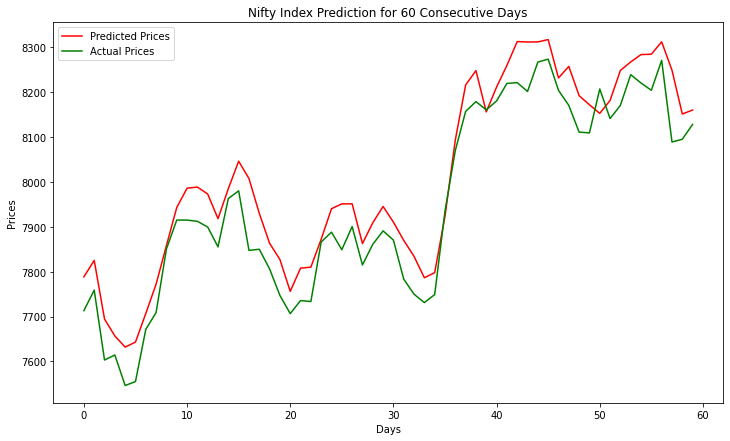

RMSE: 67.62061317753383
CPU times: user 462 ms, sys: 8.06 ms, total: 470 ms
Wall time: 472 ms


In [96]:
%%time
prediction_multiple_days_quantized()

#Summary

Our Quantized Model worked very well. Here is the summary of results.

In [100]:
from prettytable import PrettyTable
    
x = PrettyTable()

x.field_names = ["Model", "Time Taken to Predict", "RMSE"]

x.add_row(["Regular Model: Single Day Price Prediction", "649 ms", "-"])
x.add_row(["Regular Model with Quantization: Single Day Price Prediction", "60.8 ms", "-"])
x.add_row(["Regular Model: 60 days Price Prediction", "3640 ms", "44.35"])
x.add_row(["Regular Model with Quantization: 60 days Price Prediction", "472 ms", "67.62"])

print(x)

+--------------------------------------------------------------+-----------------------+-------+
|                            Model                             | Time Taken to Predict |  RMSE |
+--------------------------------------------------------------+-----------------------+-------+
|          Regular Model: Single Day Price Prediction          |         649 ms        |   -   |
| Regular Model with Quantization: Single Day Price Prediction |        60.8 ms        |   -   |
|           Regular Model: 60 days Price Prediction            |        3640 ms        | 44.35 |
|  Regular Model with Quantization: 60 days Price Prediction   |         472 ms        | 67.62 |
+--------------------------------------------------------------+-----------------------+-------+


We can clearly observe that time for prediction has reduced significantly when we use quantized model. But accuracy got decreased as RMSE has increased in quantized model.

Quantization is a great technique when we are required to make faster prediction without caring too much about accuracy. These models consume lesser space as well. These models are perfect for Mobile and Online Applications use where we need quick results.